# Evalute model performance

We can calculate the distance between labeled coordinates and the coordinates extracted from the model predicted segmentation masks.


In [1]:
!pip install albumentations==1.3.0
!git clone https://github.com/kevin-allen/unetTracker
!pip install -r unetTracker/requirements.txt
!pip install -e unetTracker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1
Cloning into 'unetTracker'...
remote: Enumerating objects: 941, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 941 (delta 194), reused 309 (delta 188), pack-reused 621
Receiving objects: 100% (941/941), 123.86 MiB | 25.60 MiB/s, done.
Resolving deltas: 100% (584/584), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.0/380.0 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 7.4

Obtaining file:///content/unetTracker
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for unetTracker (pyproject.toml) ... done
  Created wheel for unetTracker: filename=unetTracker-0.0.1-0.editable-py3-none-any.whl size=16048 sha256=b9139d9a7e6f2e690cd3ec1c03a6706ee85569d4211c7a05bbcaefcc107296be
  Stored in directory: /tmp/pip-ephem-wheel-cache-jwytfutg/wheels/62/9b/5a/0cb547490a9187d698861d98e1e803c5e64f31a9d899a8e84c
Successfully built unetTracker


In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

fn = "/content/drive/My Drive/dsfolder"
if os.path.exists(fn):
  print("We can access the dsfolder directory.")
else:
  raise IOError("Problem accessing the dsfolder directory.")

Mounted at /content/drive
We can access the dsfolder directory.


In [2]:
# this will run the code in the setup_project.py and create a variable called `project`
fn = "/content/drive/My Drive/dsfolder/setup_project.py"
if os.path.exists(fn):
  print("We can access the file.")
else:
  raise IOError("Problem accessing the file.")

%run "/content/drive/My Drive/dsfolder/setup_project.py"

We can access the file.
Project directory: /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker
Getting configuration from config file. Values from config file will be used.
Loading /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/config.yalm
{'augmentation_HorizontalFlipProb': 0.5, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_extension': '.png', 'image_size': [270, 480], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'finger_tracker', 'normalization_values': {'means': [0.40666553378105164, 0.45300230383872986, 0.5148566961288452], 'stds': [0.23905879259109497, 0.2506697177886963, 0.2679229974746704]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (240.0, 255.0, 255.0)], 'objects': ['f1', 'f2', 'f3', 'f4'], 'target_radius': 6, 'unet_features': [64, 128, 256, 512]}


In [8]:
import torch
from torch.utils.data import DataLoader


from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet
from unetTracker.coordinatesFromSegmentationMask import CoordinatesFromSegmentationMask

In [9]:
TRAIN_IMAGE_DIR = os.path.join(project.dataset_dir,"train_images")
TRAIN_MASK_DIR =  os.path.join(project.dataset_dir,"train_masks")
TRAIN_COORDINATE_DIR = os.path.join(project.dataset_dir,"train_coordinates")
VAL_IMAGE_DIR = os.path.join(project.dataset_dir,"val_images")
VAL_MASK_DIR =  os.path.join(project.dataset_dir,"val_masks")
VAL_COORDINATE_DIR = os.path.join(project.dataset_dir,"val_coordinates")



DEVICE = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
BATCH_SIZE = 2
NUM_WORKERS = 2
PIN_MEMORY=False

In [10]:
fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))
print(valTransform)

Loading valTransform from /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/augmentation/valTransform
Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.40666553378105164, 0.45300230383872986, 0.5148566961288452], std=[0.23905879259109497, 0.2506697177886963, 0.2679229974746704], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [11]:
valDataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=valTransform)
trainDataset = UNetDataset(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR,TRAIN_COORDINATE_DIR, transform=valTransform) # use same transform as for val
dataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=None)

valLoader = DataLoader(valDataset,shuffle=False,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory = PIN_MEMORY)
trainLoader = DataLoader(trainDataset,shuffle=False,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory = PIN_MEMORY)

In [12]:
model = Unet(in_channels=3, out_channels=len(project.object_list)).to(DEVICE)
project.load_model(model)
a = model.eval()

Let's get an item from the validation dataset

In [13]:
len(trainDataset)

127

In [14]:
imageIndex=1
image,mask,coord = valDataset[imageIndex]
imageOri,_,_ =dataset[imageIndex]

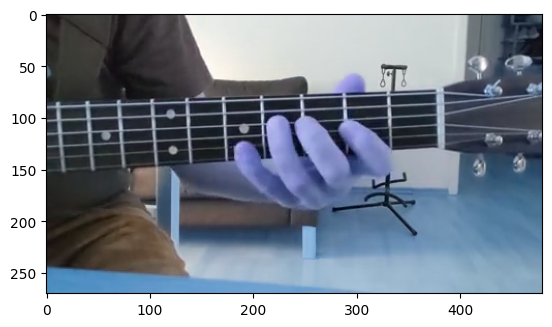

In [15]:
imageOri =imageOri.permute(1,2,0).numpy()
imageOri = imageOri.astype(np.uint8)
plt.imshow(imageOri)

In [16]:
cDetector = CoordinatesFromSegmentationMask()

In [17]:
from unetTracker.utils import check_accuracy

In [18]:
check_accuracy(model,valLoader,DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Number of positive pixels predicted: 4484.0
Number of positive pixels in masks: 5559.0
Percentage of positive pixels predicted: 0.067
Percentage of positive pixels in masks: 0.082
Accuracy: 99.934
Dice score: 0.561
Mask pixels detected (True positives): 50.351%
False positives: 37.578%
Mean distance: 5.503580739980995


In [19]:
check_accuracy(model,trainLoader,DEVICE)

Number of positive pixels predicted: 49530.0
Number of positive pixels in masks: 54609.0
Percentage of positive pixels predicted: 0.075
Percentage of positive pixels in masks: 0.083
Accuracy: 99.954
Dice score: 0.708
Mask pixels detected (True positives): 67.877%
False positives: 25.163%
Mean distance: 2.8156516332331383
